# The Analysis Pipeline

_Alex Malz (NYU) & Phil Marshall (SLAC)_

In this notebook we use the "survey mode" machinery to demonstrate how one should choose the optimal parametrization for photo-$z$ PDF storage given the nature of the data, the storage constraints, and the fidelity necessary for a science use case.

In [5]:
#comment out for NERSC
%load_ext autoreload

#comment out for NERSC
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from __future__ import print_function
    
import pickle
import hickle
import numpy as np
import random
import cProfile
import pstats
import StringIO
import sys
import os
import timeit
import bisect
import re

import qp
from qp.utils import calculate_kl_divergence as make_kld

# np.random.seed(seed=42)
# random.seed(a=42)

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'

#comment out for NERSC
%matplotlib inline

## Analysis

We want to compare parametrizations for large catalogs, so we'll need to be more efficient.  The `qp.Ensemble` object is a wrapper for `qp.PDF` objects enabling conversions to be performed and metrics to be calculated in parallel.  We'll experiment on a subsample of 100 galaxies.

In [8]:
def setup_dataset(dataset_key, skip_rows, skip_cols):
    start = timeit.default_timer()
    with open(dataset_info[dataset_key]['filename'], 'rb') as data_file:
        lines = (line.split(None) for line in data_file)
        for r in range(skip_rows):
            lines.next()
        pdfs = np.array([[float(line[k]) for k in range(skip_cols, len(line))] for line in lines])
    print('read in data file in '+str(timeit.default_timer()-start))
    return(pdfs)

In [9]:
def make_instantiation(dataset_key, n_gals_use, pdfs, bonus=None):
    
    start = timeit.default_timer()
    
    n_gals_tot = len(pdfs)
    full_gal_range = range(n_gals_tot)
    subset = np.random.choice(full_gal_range, n_gals_use, replace=False)#range(n_gals_use)
#     subset = indices
    print('randos for debugging: '+str(subset))
    pdfs_use = pdfs[subset]
    
    modality = []
    dpdfs = pdfs_use[:,1:] - pdfs_use[:,:-1]
    iqrs = []
    for i in range(n_gals_use):
        modality.append(len(np.where(np.diff(np.signbit(dpdfs[i])))[0]))
        cdf = np.cumsum(qp.utils.normalize_integral((dataset_info[dataset_key]['z_grid'], pdfs_use[i]), vb=False)[1])
        iqr_lo = dataset_info[dataset_key]['z_grid'][bisect.bisect_left(cdf, 0.25)]
        iqr_hi = dataset_info[dataset_key]['z_grid'][bisect.bisect_left(cdf, 0.75)]
        iqrs.append(iqr_hi - iqr_lo)
    modality = np.array(modality)
        
    dataset_info[dataset_key]['N_GMM'] = int(np.median(modality))+1
#     print('n_gmm for '+dataset_info[dataset_key]['name']+' = '+str(dataset_info[dataset_key]['N_GMM']))
      
    # using the same grid for output as the native format, but doesn't need to be so
    dataset_info[dataset_key]['in_z_grid'] = dataset_info[dataset_key]['z_grid']
    dataset_info[dataset_key]['metric_z_grid'] = dataset_info[dataset_key]['z_grid']
    
    print('preprocessed data in '+str(timeit.default_timer()-start))
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, 'pzs'+str(n_gals_use)+dataset_key+bonus)
    with open(loc+'.hkl', 'w') as filename:
        info = {}
        info['randos'] = randos
        info['z_grid'] = dataset_info[dataset_key]['in_z_grid']
        info['pdfs'] = pdfs_use
        info['modes'] = modality
        info['iqrs'] = iqrs
        hickle.dump(info, filename)
    
    return(pdfs_use)

In [10]:
def plot_examples(n_gals_use, dataset_key, bonus=None, norm=False):
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, 'pzs'+str(n_gals_use)+dataset_key+bonus)
    with open(loc+'.hkl', 'r') as filename:
        info = hickle.load(filename)
        randos = info['randos']
        z_grid = info['z_grid']
        pdfs = info['pdfs']
    
    plt.figure()
    for i in range(n_plot):
        data = (z_grid, pdfs[randos[i]])
        data = qp.utils.normalize_integral(qp.utils.normalize_gridded(data))
        pz_max.append(np.max(data))
        plt.plot(data[0], data[1], label=dataset_info[dataset_key]['name']+' \#'+str(randos[i]), color=color_cycle[i])
    plt.xlabel(r'$z$', fontsize=14)
    plt.ylabel(r'$p(z)$', fontsize=14)
    plt.xlim(min(z_grid), max(z_grid))
    plt.title(dataset_info[dataset_key]['name']+' data examples', fontsize=16)
    if norm:
        plt.ylim(0., max(pz_max))
        plt.savefig(loc+'norm.pdf', dpi=250)
    else:
        plt.savefig(loc+'.pdf', dpi=250)
    plt.close()
    
    if 'modes' in info.keys():
        modes = info['modes']
        modes_max.append(np.max(modes))
        plt.figure()
        ax = plt.hist(modes, color='k', alpha=1./n_plot, histtype='stepfilled', bins=range(max(modes_max)+1))
        plt.xlabel('modes')
        plt.ylabel('frequency')
        plt.title(dataset_info[dataset_key]['name']+' data modality distribution (median='+str(dataset_info[dataset_key]['N_GMM'])+')', fontsize=16)
        plt.savefig(loc+'modality.pdf', dpi=250)
        plt.close()
        
    if 'iqrs' in info.keys():
        iqrs = info['iqrs']
        iqr_min.append(min(iqrs))
        iqr_max.append(max(iqrs))
        plot_bins = np.linspace(min(iqr_min), max(iqr_max), 20)
        plt.figure()
        ax = plt.hist(iqrs, bins=plot_bins, color='k', alpha=1./n_plot, histtype='stepfilled')
        plt.xlabel('IQR')
        plt.ylabel('frequency')
        plt.title(dataset_info[dataset_key]['name']+' data IQR distribution', fontsize=16)
        plt.savefig(loc+'iqrs.pdf', dpi=250)
        plt.close()

We're going to incrementally save the quantities that are costly to calculate.

In [11]:
def save_one_stat(dataset_name, n_gals_use, N_f, i, stat, stat_name):
    path = os.path.join(dataset_name, str(n_gals_use))
    loc = os.path.join(path, stat_name+str(n_gals_use)+dataset_name+str(N_f)+'_'+str(i))
    with open(loc+'.hkl', 'w') as filename:
        hickle.dump(stat, filename)
        
def load_one_stat(dataset_name, n_gals_use, N_f, i, stat_name):
    path = os.path.join(dataset_name, str(n_gals_use))
    loc = os.path.join(path, stat_name+str(n_gals_use)+dataset_name+str(N_f)+'_'+str(i))
    with open(loc+'.hkl', 'r') as filename:
        stat = hickle.load(filename)
#     print(stat)
    return stat

def save_moments_wrapper(dataset_name, n_gals_use, N_f, i, stat_name):
    stat = load_one_stat(dataset_name, n_gals_use, N_f, i, stat_name)
    save_moments(dataset_name, n_gals_use, N_f, stat, stat_name)
        
def save_metrics_wrapper(dataset_name, n_gals_use, N_f, i, stat_name):
    stat = load_one_stat(dataset_name, n_gals_use, N_f, i, stat_name)
    save_nz_metrics(dataset_name, n_gals_use, N_f, stat, stat_name)
    
def clear_stats(dataset_name, n_gals_use, stat_name):
    path = os.path.join(dataset_name, str(n_gals_use))
    loc = os.path.join(path, stat_name+str(n_gals_use)+dataset_name+'.hkl')
    if os.path.isfile(loc):
        os.remove(loc)

We'll start by reading in our catalog of gridded PDFs, sampling them, fitting GMMs to the samples, and establishing a new `qp.Ensemble` object where each meber `qp.PDF` object has `qp.PDF.truth`$\neq$`None`.

In [12]:
def setup_from_grid(dataset_key, in_pdfs, z_grid, N_comps, high_res=1000, bonus=None):
    
    #read in the data, happens to be gridded
    zlim = (min(z_grid), max(z_grid))
    N_pdfs = len(in_pdfs)
    
    start = timeit.default_timer()
#     print('making the initial ensemble of '+str(N_pdfs)+' PDFs')
    E0 = qp.Ensemble(N_pdfs, gridded=(z_grid, in_pdfs), limits=dataset_info[dataset_key]['z_lim'], vb=False)
    print('made the initial ensemble of '+str(N_pdfs)+' PDFs in '+str(timeit.default_timer() - start))    
    
    #fit GMMs to gridded pdfs based on samples (faster than fitting to gridded)
    start = timeit.default_timer()
#     print('sampling for the GMM fit')
    samparr = E0.sample(high_res, vb=False)
    print('took '+str(high_res)+' samples in '+str(timeit.default_timer() - start))
    
    start = timeit.default_timer()
#     print('making a new ensemble from samples')
    Ei = qp.Ensemble(N_pdfs, samples=samparr, limits=dataset_info[dataset_key]['z_lim'], vb=False)
    print('made a new ensemble from samples in '+str(timeit.default_timer() - start))
    
    start = timeit.default_timer()
#     print('fitting the GMM to samples')
    GMMs = Ei.mix_mod_fit(comps=N_comps, vb=False)
    print('fit the GMM to samples in '+str(timeit.default_timer() - start))
    
    #set the GMMS as the truth
    start = timeit.default_timer()
#     print('making the final ensemble')
    Ef = qp.Ensemble(N_pdfs, truth=GMMs, limits=dataset_info[dataset_key]['z_lim'], vb=False)
    print('made the final ensemble in '+str(timeit.default_timer() - start))
    
    path = os.path.join(dataset_key, str(N_pdfs))
    loc = os.path.join(path, 'pzs'+str(n_gals_use)+dataset_key+bonus)
    with open(loc+'.hkl', 'w') as filename:
        info = {}
        info['randos'] = randos
        info['z_grid'] = z_grid
        info['pdfs'] = Ef.evaluate(z_grid, using='truth', norm=True, vb=False)[1]
        hickle.dump(info, filename)
        
    start = timeit.default_timer()
#     print('calculating '+str(n_moments_use)+' moments of original PDFs')
    in_moments, vals = [], []
    for n in range(n_moments_use):
        in_moments.append(Ef.moment(n, using='truth', limits=zlim, 
                                    dx=delta_z, vb=False))
        vals.append(n)
    moments = np.array(in_moments)
    print('calculated '+str(n_moments_use)+' moments of original PDFs in '+str(timeit.default_timer() - start))
    
    path = os.path.join(dataset_key, str(N_pdfs))
    loc = os.path.join(path, 'pz_moments'+str(n_gals_use)+dataset_key+bonus)
    with open(loc+'.hkl', 'w') as filename:
        info = {}
        info['truth'] = moments
        info['orders'] = vals
        hickle.dump(info, filename)
    
    return(Ef)

Next, we compute the KLD between each approximation and the truth for every member of the ensemble.  We make the `qp.Ensemble.kld` into a `qp.PDF` object of its own to compare the moments of the KLD distributions for different parametrizations.

In [13]:
def analyze_individual(E, z_grid, N_floats, dataset_key, N_moments=4, i=None, bonus=None):
    zlim = (min(z_grid), max(z_grid))
    z_range = zlim[-1] - zlim[0]
    delta_z = z_range / len(z_grid)
    path = os.path.join(dataset_key, str(n_gals_use))
    
    Eq, Eh, Es = E, E, E
    inits = {}
    for f in formats:
        inits[f] = {}
        for ff in formats:
            inits[f][ff] = None
            
    qstart = timeit.default_timer()
    inits['quantiles']['quantiles'] = Eq.quantize(N=N_floats, vb=False)
    print('finished quantization in '+str(timeit.default_timer() - qstart))
    hstart = timeit.default_timer()
    inits['histogram']['histogram'] = Eh.histogramize(N=N_floats, binrange=zlim, vb=False)
    print('finished histogramization in '+str(timeit.default_timer() - hstart))
    sstart = timeit.default_timer()
    inits['samples']['samples'] = Es.sample(samps=N_floats, vb=False)
    print('finished sampling in '+str(timeit.default_timer() - sstart))
        
    Eo = {}
    
    metric_start = timeit.default_timer()
    inloc = os.path.join(path, 'pz_moments'+str(n_gals_use)+dataset_key+bonus)
    with open(inloc+'.hkl', 'r') as infilename:
        pz_moments = hickle.load(infilename)
    
    klds, metrics, kld_moments, pz_moment_deltas = {}, {}, {}, {}
    
    for f in formats:
        fstart = timeit.default_timer()
        Eo[f] = qp.Ensemble(E.n_pdfs, truth=E.truth, 
                            quantiles=inits[f]['quantiles'], 
                            histogram=inits[f]['histogram'],
                            samples=inits[f]['samples'], 
                            limits=dataset_info[dataset_key]['z_lim'])
        
        fbonus = str(N_floats)+f+str(i)
        loc = os.path.join(path, 'pzs'+str(n_gals_use)+dataset_key+fbonus)
        with open(loc+'.hkl', 'w') as filename:
            info = {}
            info['randos'] = randos
            info['z_grid'] = z_grid
            info['pdfs'] = Eo[f].evaluate(z_grid, using=f, norm=True, vb=False)[1]
            hickle.dump(info, filename)
        print('made '+f+' ensemble in '+str(timeit.default_timer()-fstart))

        key = f
        
        fstart = timeit.default_timer()
        klds[key] = Eo[key].kld(using=key, limits=zlim, dx=delta_z, vb=False)
        print('calculated the '+key+' individual klds in '+str(timeit.default_timer() - fstart))
        
        fstart = timeit.default_timer()
        kld_moments[key] = []
        samp_metric = qp.PDF(samples=klds[key])
        gmm_metric = samp_metric.mix_mod_fit(n_components=dataset_info[dataset_key]['N_GMM'], 
                                             using='samples', vb=False)
        metrics[key] = qp.PDF(truth=gmm_metric)
        for n in range(N_moments):
            kld_moments[key].append(qp.utils.calculate_moment(metrics[key], n,
                                                          using='truth', 
                                                          limits=zlim, 
                                                          dx=delta_z, 
                                                          vb=False))
        save_one_stat(name, size, n_floats_use, i, kld_moments, 'pz_kld_moments')
        print('calculated the '+key+' kld moments in '+str(timeit.default_timer() - fstart))
        
        pz_moment_deltas[key], pz_moments[key] = [], []
        for n in range(N_moments):
            start = timeit.default_timer()
            new_moment = Eo[key].moment(n, using=key, limits=zlim, 
                                                  dx=delta_z, vb=False)
            pz_moments[key].append(new_moment)
            #NOTE: delta_moment is crazy for clean data!
            delta_moment = (new_moment - pz_moments['truth'][n]) / pz_moments['truth'][n]
            pz_moment_deltas[key].append(delta_moment)
            print('calculated the '+key+' individual moment '+str(n)+' in '+str(timeit.default_timer() - start))
        save_one_stat(name, size, n_floats_use, i, pz_moments, 'pz_moments')
        save_one_stat(name, size, n_floats_use, i, pz_moment_deltas, 'pz_moment_deltas')
        
    loc = os.path.join(path, 'kld_hist'+str(n_gals_use)+dataset_key+str(N_floats)+'_'+str(i))
    with open(loc+'.hkl', 'w') as filename:
        info = {}
        info['z_grid'] = z_grid
        info['N_floats'] = N_floats
        info['pz_klds'] = klds
        hickle.dump(info, filename)

    outloc = os.path.join(path, 'pz_moments'+str(n_gals_use)+dataset_key+str(N_floats)+'_'+str(i))
    with open(outloc+'.hkl', 'w') as outfilename:
        hickle.dump(pz_moments, outfilename)
    
#     save_moments(name, size, n_floats_use, kld_moments, 'pz_kld_moments')
#     save_moments(name, size, n_floats_use, pz_moments, 'pz_moments')
#     save_moments(name, size, n_floats_use, pz_moment_deltas, 'pz_moment_deltas')
    
    return(Eo)#, klds, kld_moments, pz_moments, pz_moment_deltas)

In [14]:
def plot_all_examples(name, size, N_floats, init, bonus={}):
    path = os.path.join(name, str(size))
    fig, ax = plt.subplots()
#     fig_check, ax_check = plt.subplots()
    lines = []
    loc = os.path.join(path, 'pzs'+str(size)+name+'_postfit'+str(init))
    with open(loc+'.hkl', 'r') as filename:
        info = hickle.load(filename)
        ref_pdfs = info['pdfs']  
#     klds = {}
    for bonus_key in bonus.keys():
        loc = os.path.join(path, 'pzs'+str(size)+name+bonus_key)
        with open(loc+'.hkl', 'r') as filename:
            info = hickle.load(filename)
            randos = info['randos']
            z_grid = info['z_grid']
            pdfs = info['pdfs']
        ls = bonus[bonus_key][0]
        a = bonus[bonus_key][1]
        lab = re.sub(r'[\_]', '', bonus_key)
        line, = ax.plot([-1., 0.], [0., 0.], linestyle=ls, alpha=a, color='k', label=lab[:-1])
        lines.append(line)
        leg = ax.legend(loc='upper right', handles=lines)
#         klds[bonus_key] = []
        for i in range(n_plot):
            data = (z_grid, pdfs[randos[i]])
            data = qp.utils.normalize_integral(qp.utils.normalize_gridded(data))
            ax.plot(data[0], data[1], linestyle=ls, alpha=a, color=color_cycle[i])
            #     ax.legend(loc='upper right')
#         for i in range(size):
#             data = (z_grid, pdfs[i])
#             kld = qp.utils.quick_kl_divergence(ref_pdfs[i], pdfs[i], dx=0.01)
#             klds[bonus_key].append(kld)
#     plot_bins = np.linspace(-3., 3., 20)
#     for bonus_key in bonus.keys()[1:-1]:
#         ax_check.hist(np.log(np.array(klds[bonus_key])), alpha=a, 
#                       histtype='stepfilled', edgecolor='k', 
#                       label=bonus_key, normed=True, bins=plot_bins, lw=2)
    ax.set_xlabel(r'$z$', fontsize=14)
    ax.set_ylabel(r'$p(z)$', fontsize=14)
    ax.set_xlim(min(z_grid), max(z_grid))
    ax.set_title(dataset_info[name]['name']+r' examples with $N_{f}=$'+str(N_floats), fontsize=16)
    saveloc = os.path.join(path, 'pzs'+str(size)+name+str(N_floats)+'all'+str(init))
    fig.savefig(saveloc+'.pdf', dpi=250)
#     ax_check.legend()
#     ax_check.set_ylabel('frequency', fontsize=14)
#     ax_check.set_xlabel(r'$\mathrm{KLD}$', fontsize=14)
#     ax_check.set_title(name+r' data $p(\mathrm{KLD})$ with $N_{f}='+str(N_floats)+r'$', fontsize=16)
#     fig_check.savefig(saveloc+'kld_check.pdf', dpi=250)
    plt.close()
#     with open(saveloc+'.p', 'w') as kldfile:
#         pickle.dump(klds, kldfile)
        

In [15]:
def plot_individual_kld(n_gals_use, dataset_key, N_floats, i):
    
    path = os.path.join(dataset_key, str(n_gals_use))
    a = 1./len(formats)
    loc = os.path.join(path, 'kld_hist'+str(n_gals_use)+dataset_key+str(N_floats)+'_'+str(i))
    with open(loc+'.hkl', 'r') as filename:
        info = hickle.load(filename)
        z_grid = info['z_grid']
        N_floats = info['N_floats']
        pz_klds = info['pz_klds']
    
    plt.figure()
    plot_bins = np.linspace(-10., 5., 30)
    for key in pz_klds.keys():
        logdata = qp.utils.safelog(pz_klds[key])
        dist_min.append(min(logdata))
        dist_max.append(max(logdata))
#         plot_bins = np.linspace(-10., 5., 20)
        kld_hist = plt.hist(logdata, color=colors[key], alpha=a, histtype='stepfilled', edgecolor='k',
             label=key, normed=True, bins=plot_bins, linestyle=stepstyles[key], ls=stepstyles[key], lw=2)
#         kld_hist = plt.hist(pz_klds[key], color=colors[key], alpha=a, histtype='stepfilled', edgecolor='k',
#              label=key, normed=True, bins=plot_bins, linestyle=stepstyles[key], ls=stepstyles[key], lw=2)
        hist_max.append(max(kld_hist[0]))
    print(loc+': min KLD='+str(np.argmin(logdata)))
    plt.legend()
    plt.ylabel('frequency', fontsize=14)
#     plt.xlabel(r'$\log[\mathrm{KLD}]$', fontsize=14)
    plt.xlabel(r'$\mathrm{KLD}$', fontsize=14)
#     plt.xlim(min(dist_min), max(dist_max))
#     plt.ylim(0., max(hist_max))
    plt.title(dataset_info[dataset_key]['name']+r' data $p(\mathrm{KLD})$ with $N_{f}='+str(N_floats)+r'$', fontsize=16)
    plt.savefig(loc+'.pdf', dpi=250)
    plt.close()

In [ ]:
def plot_all_kld(size, name, i):
    path = os.path.join(name, str(size))
    fig, ax = plt.subplots()
    fig.canvas.draw()
    for i in instantiations:
        to_plot = {}
        for f in formats:
            to_plot[f] = []
        for Nf in floats:
            place = os.path.join(path, 'kld_hist'+str(size)+name+str(Nf)+'_'+str(i))
            with open(place+'.hkl', 'r') as filename:
                klds = hickle.load(filename)['pz_klds']
                for f in formats:
                    to_plot[f].append(klds[f])
#                         print(name, size, i, Nf, f, klds[f])
        for f in formats:
            to_plot[f] = np.array(to_plot[f])
            delta_info = np.ones((len(floats), size))
            for Nf in floats:
                delta_info[:-1] = to_plot[f][1:] - to_plot[f][:-1]
                delta_info[-1] = -1. * to_plot[f][-1]
            ax.plot(floats, delta_info, color=colors[f])
        ax.set_xlabel()
        ax.set_ylabel()
        ax.semilogx()
        ax.set_xticks(floats)
        ax.set_xticklabels([r'$3\to 10$', r'$10\to 30$', r'$30\to 100$', r'$100\to \infty$'])

Finally, we calculate metrics on the stacked estimator $\hat{n}(z)$ that is the average of all members of the ensemble.

In [16]:
def analyze_stacked(E0, E, z_grid, n_floats_use, dataset_key, i=None):
    
    zlim = (min(z_grid), max(z_grid))
    z_range = zlim[-1] - zlim[0]
    delta_z = z_range / len(z_grid)
    
    n_gals_use = E0.n_pdfs
    
#     print('stacking the ensembles')
#     stack_start = timeit.default_timer()
    stacked_pdfs, stacks = {}, {}
    for key in formats:
        start = timeit.default_timer()
        stacked_pdfs[key] = qp.PDF(gridded=E[key].stack(z_grid, using=key, 
                                                        vb=False)[key])
        stacks[key] = stacked_pdfs[key].evaluate(z_grid, using='gridded', norm=True, vb=False)[1]
        print('stacked '+key+ ' in '+str(timeit.default_timer()-start))
    
    stack_start = timeit.default_timer()
    stacked_pdfs['truth'] = qp.PDF(gridded=E0.stack(z_grid, using='truth', 
                                                    vb=False)['truth'])
    
    stacks['truth'] = stacked_pdfs['truth'].evaluate(z_grid, using='gridded', norm=True, vb=False)[1]
    print('stacked truth in '+str(timeit.default_timer() - stack_start))
    
    klds = {}
    for key in formats:
        kld_start = timeit.default_timer()
        klds[key] = qp.utils.calculate_kl_divergence(stacked_pdfs['truth'],
                                                     stacked_pdfs[key], 
                                                     limits=zlim, dx=delta_z)
        print('calculated the '+key+' stacked kld in '+str(timeit.default_timer() - kld_start))
    save_one_stat(dataset_key, n_gals_use, n_floats_use, i, klds, 'nz_klds')
#     save_nz_metrics(name, size, n_floats_use, klds, 'nz_klds')
        
    moments = {}
    for key in formats_plus:
        moment_start = timeit.default_timer()
        moments[key] = []
        for n in range(n_moments_use):
            moments[key].append(qp.utils.calculate_moment(stacked_pdfs[key], n, 
                                                          limits=zlim, 
                                                          dx=delta_z, 
                                                          vb=False))
        print('calculated the '+key+' stacked moments in '+str(timeit.default_timer() - moment_start))
    save_one_stat(dataset_key, n_gals_use, n_floats_use, i, moments, 'nz_moments')
#     save_moments(name, size, n_floats_use, moments, 'nz_moments') 
    
    path = os.path.join(dataset_key, str(E0.n_pdfs))
    loc = os.path.join(path, 'nz_comp'+str(n_gals_use)+dataset_key+str(n_floats_use)+'_'+str(i))
    with open(loc+'.hkl', 'w') as filename:
        info = {}
        info['z_grid'] = z_grid
        info['stacks'] = stacks
        info['klds'] = klds
        info['moments'] = moments
        hickle.dump(info, filename)
    
    return(stacked_pdfs)

In [17]:
def plot_estimators(n_gals_use, dataset_key, n_floats_use, i=None):
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, 'nz_comp'+str(n_gals_use)+dataset_key+str(n_floats_use)+'_'+str(i))
    with open(loc+'.hkl', 'r') as filename:
        info = hickle.load(filename)
        z_grid = info['z_grid']
        stacks = info['stacks']
        klds = info['klds']
    
    plt.figure()
    plt.plot(z_grid, stacks['truth'], color='black', lw=3, alpha=0.3, label='original')
    nz_max.append(max(stacks['truth']))
    for key in formats:
        nz_max.append(max(stacks[key]))
        plt.plot(z_grid, stacks[key], label=key+r' KLD='+str(klds[key])[:8], color=colors[key], linestyle=styles[key])
    plt.xlabel(r'$z$', fontsize=14)
    plt.ylabel(r'$\hat{n}(z)$', fontsize=14)
    plt.xlim(min(z_grid), max(z_grid))
#     plt.ylim(0., max(nz_max))
    plt.legend()
    plt.title(dataset_info[dataset_key]['name']+r' data $\hat{n}(z)$ with $N_{f}='+str(n_floats_use)+r'$', fontsize=16)
    plt.savefig(loc+'.pdf', dpi=250)
    plt.close()

We save the data so we can remake the plots later without running everything again.

## Scaling

We'd like to do this for many values of $N_{f}$ as well as larger catalog subsamples, repeating the analysis many times to establish error bars on the KLD as a function of format, $N_{f}$, and dataset.  The things we want to plot across multiple datasets/number of parametes are:

1. KLD of stacked estimator, i.e. `N_f` vs. `nz_output[dataset][format][instantiation][KLD_val_for_N_f]`
2. moments of KLD of individual PDFs, i.e. `n_moment, N_f` vs. `pz_output[dataset][format][n_moment][instantiation][moment_val_for_N_f]`

So, we ned to make sure these are saved!

We want to plot the moments of the KLD distribution for each format as $N_{f}$ changes.

In [18]:
def save_moments(dataset_name, n_gals_use, N_f, stat, stat_name):

    path = os.path.join(dataset_name, str(n_gals_use))
    loc = os.path.join(path, stat_name+str(n_gals_use)+dataset_name)
    
    if os.path.exists(loc+'.hkl'):
        with open(loc+'.hkl', 'r') as stat_file:
        #read in content of list/dict
            stats = hickle.load(stat_file)
    else:
        stats = {}
        stats['N_f'] = []
        for f in stat.keys():
            stats[f] = []
            for m in range(n_moments_use):
                stats[f].append([])

    if N_f not in stats['N_f']:
        stats['N_f'].append(N_f)
        for f in stat.keys():
            for m in range(n_moments_use):
                stats[f][m].append([])
        
    where_N_f = stats['N_f'].index(N_f)
        
    for f in stat.keys():
        for m in range(n_moments_use):
            stats[f][m][where_N_f].append(stat[f][m])

    with open(loc+'.hkl', 'w') as stat_file:
        hickle.dump(stats, stat_file)

In [140]:
# include second axis with mean KLD values?
# somehow combining pz_kld_moments with this?
def plot_kld_stats(name, size):
    a = 1./len(formats)
    topdir = os.path.join(name, str(size))
    
    fig_one, ax_one = plt.subplots(figsize=(5, 5))
    fig_one.canvas.draw()
    mean_deltas, std_deltas = {}, {}
    for f in formats:
        mean_deltas[f], std_deltas[f] = [], []
        ax_one.plot([1000., 1000.], [1., 10.], color=colors[f], alpha=a, label=f, linestyle=styles[f])
    for i in instantiations:
        to_plot = {}
        for f in formats:
            to_plot[f] = []
            mean_deltas[f].append([])
            std_deltas[f].append([])
        for Nf in floats:
            loc = os.path.join(topdir, 'kld_hist'+str(size)+name+str(Nf)+'_'+str(i))
            with open(loc+'.hkl', 'r') as filename:
                klds = hickle.load(filename)['pz_klds']
                for f in formats:
                    to_plot[f].append(klds[f])
        for f in formats:
            to_plot[f] = np.array(to_plot[f])
            delta_info = np.ones((len(floats), size))
            delta_info[:-1] = to_plot[f][:-1] - to_plot[f][1:]
            delta_info[-1] = to_plot[f][-1]
            delta_info[delta_info < qp.utils.epsilon] = qp.utils.epsilon
#             log_delta_info = np.log(delta_info)
#             ax_one.plot(floats, log_delta_info)
            mean_deltas[f][i] = np.mean(delta_info, axis=1)
            std_deltas[f][i] = np.std(delta_info, axis=1)
            indie_delta_kld_min.append(np.min(mean_deltas[f][i] - std_deltas[f][i]))
            indie_delta_kld_max.append(np.max(mean_deltas[f][i] + std_deltas[f][i]))
            ax_one.plot(floats, mean_deltas[f][i], color=colors[f], alpha=a, linestyle=styles[f])
    ax_one.set_ylabel(r'$\Delta\mathrm{KLD}$')
    ax_one.semilogy()
    ax_one.set_ylim(np.min(indie_delta_kld_min), np.max(indie_delta_kld_max))
    ax_one.set_xlim(min(floats), max(floats))
    ax_one.set_xlabel('change in number of parameters')
    ax_one.semilogx()
    ax_one.set_xticks(floats)
    ax_one.set_xticklabels([r'$3\to 10$', r'$10\to 30$', r'$30\to 100$', r'$100\to \infty$'])
    ax_one.legend(loc='upper right')
    ax_one.set_title(dataset_info[name]['name']+r' data per-PDF $\Delta\mathrm{KLD}$', fontsize=16)
    place = os.path.join(topdir, 'indie_klds'+str(size)+name)
    fig_one.savefig(place+'_each.pdf', dpi=250)
    plt.close
    
    fig, ax = plt.subplots(figsize=(5, 5))
    for f in formats:
        mean_deltas[f] = np.array(mean_deltas[f])
#         std_deltas[f] = np.array(std_deltas[f])
        global_delta_mean = np.mean(mean_deltas[f], axis=0)
        global_delta_std = np.std(mean_deltas[f], axis=0)
        x_cor = np.array([floats[:-1], floats[:-1], floats[1:], floats[1:]])
        y_plus = global_delta_mean + global_delta_std
        y_minus = global_delta_mean - global_delta_std
        indie_delta_kld_min.append(np.min(y_minus))
        indie_delta_kld_max.append(np.max(y_plus))
        y_cor = np.array([y_minus[:-1], y_plus[:-1], y_plus[1:], y_minus[1:]])
        ax.fill(x_cor, y_cor, color=colors[f], alpha=a, linewidth=0.)
        ax.plot(floats, global_delta_mean, color=colors[f], linestyle=styles[f], label=f)
    ax.set_ylabel(r'$\Delta\mathrm{KLD}$')
    ax.semilogy()
    ax.set_ylim(np.min(indie_delta_kld_min), np.max(indie_delta_kld_max))
    ax.set_xlim(min(floats), max(floats))
    ax.set_xlabel('change in number of parameters')
    ax.semilogx()
    ax.set_xticks(floats)
    ax.set_xticklabels([r'$3\to 10$', r'$10\to 30$', r'$30\to 100$', r'$100\to \infty$'])
    ax.legend(loc='upper right')
    ax.set_title(dataset_info[name]['name']+r' data per-PDF $\Delta\mathrm{KLD}$', fontsize=16)
    place = os.path.join(topdir, 'indie_klds'+str(size)+name)
    fig.savefig(place+'_clean.pdf', dpi=250)
    plt.close

In [19]:
def plot_pz_metrics(dataset_key, n_gals_use):

    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, 'pz_kld_moments'+str(n_gals_use)+dataset_key)
    with open(loc+'.hkl', 'r') as pz_file:
        pz_stats = hickle.load(pz_file)
  
    flat_floats = np.array(pz_stats['N_f']).flatten()
    in_x = np.log(flat_floats)

    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)

    shapes = moment_shapes
    marksize = 10
    a = 1./len(formats)
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    ax_n = ax
    for key in formats:
        ax.plot([-1], [0], color=colors[key], label=key, linewidth=1, linestyle=styles[key], alpha=a)
    for n in range(1, n_moments_use):
        ax.scatter([-1], [0], color='k', alpha=a, marker=shapes[n], facecolors='none', s=2*marksize, label=moment_names[n])
        n_factor = 0.1 * (n - 2)
        if n>1:
            ax_n = ax.twinx()
            rot_ang = 270
            label_space = 15.
        else:
            rot_ang = 90
            label_space = 0.
        if n>2:
            ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (n-1)))
            make_patch_spines_invisible(ax_n)
            ax_n.spines["right"].set_visible(True)
        for s in range(len(formats)):
            f = formats[s]
            f_factor = 0.05 * (s - 1)
#             print('pz metrics data shape '+str(pz_stats[f][n]))
            data_arr = np.log(np.swapaxes(np.array(pz_stats[f][n]), 0, 1))#go from n_floats*instantiations to instantiations*n_floats
            mean = np.mean(data_arr, axis=0).flatten()
            std = np.std(data_arr, axis=0).flatten()
            y_plus = mean + std
            y_minus = mean - std
#             y_cor = np.array([y_minus[:-1], y_plus[:-1], y_plus[1:], y_minus[1:]])
            ax_n.plot(np.exp(in_x+n_factor), mean, marker=shapes[n], mfc='none', markersize=marksize, linestyle=styles[f], alpha=a, color=colors[f])
            ax_n.vlines(np.exp(in_x+n_factor), y_minus, y_plus, linewidth=3., alpha=a, color=colors[f])
            pz_mean_max[n] = max(pz_mean_max[n], np.max(y_plus))
            pz_mean_min[n] = min(pz_mean_min[n], np.min(y_minus))
        ax_n.set_ylabel(r'$\log[\mathrm{'+moment_names[n]+r'}]$', rotation=rot_ang, fontsize=14, labelpad=label_space)
        ax_n.set_ylim((pz_mean_min[n]-1., pz_mean_max[n]+1.))
    ax.set_xscale('log')
    ax.set_xticks(flat_floats)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlim(np.exp(min(in_x)-0.25), np.exp(max(in_x)+0.25))
    ax.set_xlabel('number of parameters', fontsize=14)
    ax.set_title(dataset_info[dataset_key]['name']+r' data $\log[\mathrm{KLD}]$ log-moments', fontsize=16)
    ax.legend(loc='lower right')
    fig.tight_layout()
    fig.savefig(loc+'_clean.pdf', dpi=250)
    plt.close()
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    ax_n = ax
    for key in formats:
        ax_n.plot([-1], [0], color=colors[key], label=key, linestyle=styles[key], alpha=a, linewidth=1)
    for n in range(1, n_moments_use):
        n_factor = 0.1 * (n - 2)
        ax.scatter([-1], [0], color='k', alpha=a, marker=shapes[n], facecolors='none', s=2*marksize, label=moment_names[n])
        if n>1:
            ax_n = ax.twinx()
            rot_ang = 270
            label_space = 15.
        else:
            rot_ang = 90
            label_space = 0.
        if n>2:
            ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (n-1)))
            make_patch_spines_invisible(ax_n)
            ax_n.spines["right"].set_visible(True)
        for s in range(len(formats)):
            f = formats[s]
            f_factor = 0.05 * (s - 1)
#             print('pz metrics data shape '+str(pz_stats[f][n]))
            data_arr = np.log(np.swapaxes(np.array(pz_stats[f][n]), 0, 1))#go from n_floats*instantiations to instantiations*n_floats
            for i in data_arr:
                ax_n.plot(np.exp(in_x+n_factor), i, linestyle=styles[f], marker=shapes[n], mfc='none', markersize=marksize, color=colors[f], alpha=a)
#                 pz_moment_max[n-1].append(max(i))
        ax_n.set_ylabel(r'$\log[\mathrm{'+moment_names[n]+r'}]$', rotation=rot_ang, fontsize=14, labelpad=label_space)
        ax_n.set_ylim(pz_mean_min[n]-1., pz_mean_max[n]+1.)
    ax.set_xscale('log')
    ax.set_xticks(flat_floats)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlim(np.exp(min(in_x)-0.25), np.exp(max(in_x)+0.25))
    ax.set_xlabel('number of parameters', fontsize=14)
    ax.set_title(dataset_info[dataset_key]['name']+r' data $\log[\mathrm{KLD}]$ log-moments', fontsize=16)
    ax.legend(loc='lower right')
    fig.tight_layout()
    fig.savefig(loc+'_all.pdf', dpi=250)
    plt.close()

In [20]:
def plot_pz_delta_moments(name, size):
    n_gals_use = size
    
    # should look like nz_moments
    path = os.path.join(name, str(n_gals_use))
    loc = os.path.join(path, 'pz_moment_deltas'+str(n_gals_use)+name)
    with open(loc+'.hkl', 'r') as pz_file:
        pz_stats = hickle.load(pz_file)
    flat_floats = np.array(pz_stats['N_f']).flatten()
    in_x = np.log(flat_floats)
    a = 1./len(formats)
    shapes = moment_shapes
    marksize = 10
    
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)   
            
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    ax_n = ax
    for key in formats:
        ax.plot([-10], [0], color=colors[key], label=key, linestyle=styles[key], alpha=a, linewidth=1)
    for n in range(1, n_moments_use):
        ax.scatter([-10], [0], color='k', alpha=a, marker=shapes[n], facecolors='none', s=2*marksize, label=moment_names[n])
        n_factor = 0.1 * (n - 2)
        if n>1:
            ax_n = ax.twinx()
            rot_ang = 270
            label_space = 15.
        else:
            rot_ang = 90
            label_space = 0.
        if n>2:
            ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (n-1)))
            make_patch_spines_invisible(ax_n)
            ax_n.spines["right"].set_visible(True)
        for s in range(len(formats)):
            f = formats[s]
            f_factor = 0.05 * (s - 1)
            old_shape = np.shape(np.array(pz_stats[f][n]))
            new_shape = (old_shape[0], np.prod(old_shape[1:]))
            data_arr = np.array(pz_stats[f][n]).reshape(new_shape)#go from n_floats*instantiations to instantiations*n_floats
#             data_arr = np.median(data_arr, axis=2) * 100.
            mean = np.mean(data_arr, axis=-1) * 100.
            std = np.std(data_arr, axis=-1) * 100.
            y_plus = mean + std
            y_minus = mean - std
#             y_cor = np.array([y_minus, y_plus, y_plus, y_minus])
            ax_n.plot(np.exp(in_x+n_factor), mean, linestyle=styles[key], marker=shapes[n], mfc='none', markersize=marksize, alpha=a, color=colors[f])
            ax_n.vlines(np.exp(in_x+n_factor), y_minus, y_plus, linewidth=3., alpha=a, color=colors[f])
            n_delta_max[n] = max(n_delta_max[n], np.max(y_plus))
            n_delta_min[n] = min(n_delta_min[n], np.min(y_minus))
        ax_n.set_ylabel(r'percent error on '+moment_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
        extremum = np.max(np.abs([n_delta_min[n],n_delta_max[n]]))+1.
        ax_n.set_ylim(-1.*extremum, extremum)
    ax.set_xscale('log')
    ax.set_xticks(flat_floats)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlim(np.exp(min(in_x)-0.25), np.exp(max(in_x)+0.25))
    ax.set_xlabel('number of parameters', fontsize=14)
    ax.set_title(dataset_info[name]['name']+r' data $\hat{p}(z)$ moment errors', fontsize=16)
    ax.legend(loc='lower left')
    fig.tight_layout()
    fig.savefig(loc+'_clean.pdf', dpi=250)
    plt.close()
            
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    ax_n = ax
    for key in formats:
        ax_n.plot([-10], [0], color=colors[key], label=key, linestyle=styles[key], alpha=a, linewidth=1)
    for n in range(1, n_moments_use):
        n_factor = 0.1 * (n - 2)
        ax.scatter([-10], [0], color='k', alpha=a, marker=shapes[n], facecolors='none', s=2*marksize, label=moment_names[n])
        if n>1:
            ax_n = ax.twinx()
            rot_ang = 270
            label_space = 15.
        else:
            rot_ang = 90
            label_space = 0.
        if n>2:
            ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (n-1)))
            make_patch_spines_invisible(ax_n)
            ax_n.spines["right"].set_visible(True)
        for s in range(len(formats)):
            f = formats[s]
            f_factor = 0.05 * (s - 1)
            data_arr = np.swapaxes(np.array(pz_stats[f][n]), 0, 1)
            data_arr = np.median(data_arr, axis=2) * 100.
            for i in data_arr:
                ax_n.plot(np.exp(in_x+n_factor), i, linestyle=styles[f], marker=shapes[n], mfc='none', markersize=marksize, color=colors[f], alpha=a)
        ax_n.set_ylabel(r'median percent error on '+moment_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
        ax_n.set_ylim(-1.*extremum, extremum)
    ax.set_xscale('log')
    ax.set_xticks(flat_floats)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlim(np.exp(min(in_x)-0.25), np.exp(max(in_x)+0.25))
    ax.set_xlabel('number of parameters', fontsize=14)
    ax.set_title(dataset_info[name]['name']+r' data $\hat{n}(z)$ moments', fontsize=16)
    ax.legend(loc='lower left')
    fig.tight_layout()
    fig.savefig(loc+'_all.pdf', dpi=250)
    plt.close()

We want to plot the KLD on $\hat{n}(z)$ for all formats as $N_{f}$ changes.  We want to repeat this for many subsamples of the catalog to establush error bars on the KLD values.

In [21]:
def save_nz_metrics(dataset_name, n_gals_use, N_f, nz_klds, stat_name):
    
    path = os.path.join(dataset_name, str(n_gals_use))
    loc = os.path.join(path, stat_name+str(n_gals_use)+dataset_name)
    if os.path.exists(loc+'.hkl'):
        with open(loc+'.hkl', 'r') as nz_file:
        #read in content of list/dict
            nz_stats = hickle.load(nz_file)
    else:
        nz_stats = {}
        nz_stats['N_f'] = []
        for f in formats:
            nz_stats[f] = []
    
    if N_f not in nz_stats['N_f']:
        nz_stats['N_f'].append(N_f)
        for f in formats:
            nz_stats[f].append([])
        
    where_N_f = nz_stats['N_f'].index(N_f) 
    
    for f in formats:
        nz_stats[f][where_N_f].append(nz_klds[f])

    with open(loc+'.hkl', 'w') as nz_file:
        hickle.dump(nz_stats, nz_file)

In [22]:
def plot_nz_klds(dataset_key, n_gals_use):
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, 'nz_klds'+str(n_gals_use)+dataset_key)
    with open(loc+'.hkl', 'r') as nz_file:
        nz_stats = hickle.load(nz_file)
#     if len(instantiations) == 10:
#         for f in formats:
#             if not np.shape(nz_stats[f]) == (4, 10):
#                 for s in range(len(floats)):
#                     nz_stats[f][s] = np.array(np.array(nz_stats[f][s])[:10]).flatten()

    flat_floats = np.array(nz_stats['N_f']).flatten()
    
    plt.figure(figsize=(5, 5))
    for f in formats:
#         print('nz klds data shape '+str(nz_stats[f][n]))
        data_arr = np.swapaxes(np.array(nz_stats[f]), 0, 1)#turn N_f * instantiations into instantiations * N_f
        n_i = len(data_arr)
        a = 1./len(formats)#1./n_i
        plt.plot([10. * max(flat_floats), 10. * max(flat_floats)], [1., 10.], color=colors[f], alpha=a, label=f, linestyle=styles[f])
        for i in data_arr:
            plt.plot(flat_floats, i, color=colors[f], alpha=a, linestyle=styles[f])
            kld_min.append(min(i))
            kld_max.append(max(i))
    plt.semilogy()
    plt.semilogx()
    plt.xticks(flat_floats, [str(ff) for ff in flat_floats])
    plt.ylim(min(kld_min) / 10., 10. *  max(kld_max))
    plt.xlim(min(flat_floats) / 3., max(flat_floats) * 3.)
    plt.xlabel(r'number of parameters', fontsize=14)
    plt.ylabel(r'KLD', fontsize=14)
    plt.legend(loc='upper right')
    plt.title(r'$\hat{n}(z)$ KLD on '+str(n_gals_use)+' from '+dataset_info[dataset_key]['name']+' mock catalog', fontsize=16)
    plt.savefig(loc+'_all.pdf', dpi=250)
    plt.close()

    plt.figure(figsize=(5, 5))
    a = 1./len(formats)
    for f in formats:
#         print('nz klds data shape '+str(nz_stats[f][n]))
        data_arr = np.swapaxes(np.array(nz_stats[f]), 0, 1)#turn N_f * instantiations into instantiations * N_f
        plt.plot([10. * max(flat_floats), 10. * max(flat_floats)], [1., 10.], color=colors[f], label=f, linestyle=styles[f])
        kld_min.append(np.min(data_arr))
        kld_max.append(np.max(data_arr))
        mean = np.mean(data_arr, axis=0)
        std = np.std(data_arr, axis=0)
        x_cor = np.array([flat_floats[:-1], flat_floats[:-1], flat_floats[1:], flat_floats[1:]])
        y_plus = mean + std
        y_minus = mean - std
        y_cor = np.array([y_minus[:-1], y_plus[:-1], y_plus[1:], y_minus[1:]])
        plt.plot(flat_floats, mean, color=colors[f], linestyle=styles[f])
        plt.fill(x_cor, y_cor, color=colors[f], alpha=a, linewidth=0.)
    plt.semilogy()
    plt.semilogx()
    plt.xticks(flat_floats, [str(ff) for ff in flat_floats])
    plt.ylim(min(kld_min) / 10., 10. *  max(kld_max))
    plt.xlim(min(flat_floats), max(flat_floats))
    plt.xlabel(r'number of parameters', fontsize=14)
    plt.ylabel(r'KLD', fontsize=14)
    plt.legend(loc='upper right')
    plt.title(dataset_info[dataset_key]['name']+r' data $\hat{n}(z)$ KLD', fontsize=16)
    plt.savefig(loc+'_clean.pdf', dpi=250)
    plt.close()

In [23]:
def plot_nz_moments(dataset_key, n_gals_use):

    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, 'nz_moments'+str(n_gals_use)+dataset_key)
    with open(loc+'.hkl', 'r') as nz_file:
        nz_stats = hickle.load(nz_file)
    flat_floats = np.array(nz_stats['N_f']).flatten()
    in_x = np.log(flat_floats)
    a = 1./len(formats)
    shapes = moment_shapes
    marksize = 10
    
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)   
            
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    ax_n = ax
    for key in formats:
        ax.plot([-10], [0], color=colors[key], label=key, linestyle=styles[key], alpha=a, linewidth=1)
    for n in range(1, n_moments_use):
        ax.scatter([-10], [0], color='k', alpha=a, marker=shapes[n], facecolors='none', s=2*marksize, label=moment_names[n])
        n_factor = 0.1 * (n - 2)
        truth = np.swapaxes(np.array(nz_stats['truth'][n]), 0, 1)
        if n>1:
            ax_n = ax.twinx()
            rot_ang = 270
            label_space = 15.
        else:
            rot_ang = 90
            label_space = 0.
        if n>2:
            ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (n-1)))
            make_patch_spines_invisible(ax_n)
            ax_n.spines["right"].set_visible(True)
        for s in range(len(formats)):
            f = formats[s]
            f_factor = 0.05 * (s - 1)
            data_arr = (np.swapaxes(np.array(nz_stats[f][n]), 0, 1) - truth) / truth * 100.#np.log(np.swapaxes(np.array(nz_stats[f]), 0, 1)[:][:][n])#go from n_floats*instantiations to instantiations*n_floats
            mean = np.mean(data_arr, axis=0).flatten()
            std = np.std(data_arr, axis=0).flatten()
            y_plus = mean + std
            y_minus = mean - std
#             y_cor = np.array([y_minus[:-1], y_plus[:-1], y_plus[1:], y_minus[1:]])
            ax_n.plot(np.exp(in_x+n_factor), mean, linestyle=styles[key], marker=shapes[n], mfc='none', markersize=marksize, alpha=a, color=colors[f])
            ax_n.vlines(np.exp(in_x+n_factor), y_minus, y_plus, linewidth=3., alpha=a, color=colors[f])
            nz_mean_max[n] = max(nz_mean_max[n], np.max(y_plus))
            nz_mean_min[n] = min(nz_mean_min[n], np.min(y_minus))
        ax_n.set_ylabel(r'percent error on '+moment_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
        extremum = np.max(np.abs([nz_mean_min[n], nz_mean_max[n]]))+1.
        ax_n.set_ylim(-1. * extremum, extremum)
    ax.set_xscale('log')
    ax.set_xticks(flat_floats)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlim(np.exp(min(in_x)-0.25), np.exp(max(in_x)+0.25))
    ax.set_xlabel('number of parameters', fontsize=14)
    ax.set_title(dataset_info[dataset_key]['name']+r' data $\hat{n}(z)$ moments', fontsize=16)
    ax.legend(loc='lower right')
    fig.tight_layout()
    fig.savefig(loc+'_clean.pdf', dpi=250)
    plt.close()
            
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    ax_n = ax
    for key in formats:
        ax_n.plot([-10], [0], color=colors[key], label=key, linestyle=styles[key], alpha=a, linewidth=1)
    for n in range(1, n_moments_use):
        n_factor = 0.1 * (n - 2)
        ax.scatter([-10], [0], color='k', alpha=a, marker=shapes[n], facecolors='none', s=2*marksize, label=moment_names[n])
        truth = np.swapaxes(np.array(nz_stats['truth'][n]), 0, 1)
        if n>1:
            ax_n = ax.twinx()
            rot_ang = 270
            label_space = 15.
        else:
            rot_ang = 90
            label_space = 0.
        if n>2:
            ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (n-1)))
            make_patch_spines_invisible(ax_n)
            ax_n.spines["right"].set_visible(True)
        for s in range(len(formats)):
            f = formats[s]
            f_factor = 0.05 * (s - 1)
            data_arr = (np.swapaxes(np.array(nz_stats[f][n]), 0, 1) - truth) / truth * 100.
            for i in data_arr:
                ax_n.plot(np.exp(in_x+n_factor), i, linestyle=styles[f], marker=shapes[n], mfc='none', markersize=marksize, color=colors[f], alpha=a)
        ax_n.set_ylabel(r'percent error on '+moment_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
        ax_n.set_ylim(-1. * extremum, extremum)
    ax.set_xscale('log')
    ax.set_xticks(flat_floats)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlim(np.exp(min(in_x)-0.25), np.exp(max(in_x)+0.25))
    ax.set_xlabel('number of parameters', fontsize=14)
    ax.set_title(dataset_info[dataset_key]['name']+r' data $\hat{n}(z)$ moments', fontsize=16)
    ax.legend(loc='lower right')
    fig.tight_layout()
    fig.savefig(loc+'_all.pdf', dpi=250)
    plt.close()

# Okay, now all I have to do is have this loop over both datasets, number of galaxies, number of floats, and instantiations!

Note: It takes about 5 minutes per \# floats considered for 100 galaxies, and about 40 minutes per \# floats for 1000 galaxies.  (So, yes, it scales more or less as expected!)

In [24]:
dataset_info = {}
delta = 0.01

dataset_keys = ['mg', 'ss']

for name in dataset_keys:
    dataset_info[name] = {}
    if name == 'mg':
        datafilename = 'bpz_euclid_test_10_3.probs'
        z_low = 0.01
        z_high = 3.51
        nc_needed = 3
        plotname = 'brighter'
        skip_rows = 1
        skip_cols = 1
    elif name == 'ss':
        datafilename = 'test_magscat_trainingfile_probs.out'
        z_low = 0.005
        z_high = 2.11
        nc_needed = 5
        plotname = 'fainter'
        skip_rows = 1
        skip_cols = 1
    dataset_info[name]['filename'] = datafilename  
    
    dataset_info[name]['z_lim'] = (z_low, z_high)
    z_grid = np.arange(z_low, z_high, delta, dtype='float')#np.arange(z_low, z_high + delta, delta, dtype='float')
    z_range = z_high - z_low
    delta_z = z_range / len(z_grid)
    dataset_info[name]['z_grid'] = z_grid
    dataset_info[name]['delta_z'] = delta_z

    dataset_info[name]['N_GMM'] = nc_needed# will be overwritten later
    dataset_info[name]['name'] = plotname

In [25]:
formats = ['quantiles', 'histogram', 'samples']
formats_plus = list(formats)
formats_plus.append('truth')

high_res = 300

color_cycle = np.array([(230, 159, 0), (86, 180, 233), (0, 158, 115), (240, 228, 66), (0, 114, 178), (213, 94, 0), (204, 121, 167)])/256.
color_cycle_names = ['Orange', 'Sky blue', 'Bluish green', 'Yellow', 'Blue', 'Vermilion', 'Reddish purple']
n_plot = len(color_cycle)

n_moments_use = 4
moment_names = ['integral', 'mean', 'variance', 'kurtosis']
moment_shapes = ['o', '*', 'P', 'X']

In [26]:
#change all for NERSC

floats = [3, 10, 30, 100]
sizes = [10]#[10, 100, 1000]
names = ['ss']#dataset_info.keys()
instantiations = range(0, 1)

all_randos = [[np.random.choice(size, n_plot, replace=False) for size in sizes] for name in names]

The "pipeline" is a bunch of nested `for` loops because `qp.Ensemble` makes heavy use of multiprocessing.  Doing multiprocessing within multiprocessing may or may not cause problems, but I am certain that it makes debugging a nightmare.

Okay, without further ado, let's do it!

In [27]:
# # the "pipeline"
# global_start = timeit.default_timer()
# for n in range(len(names)):
#     name = names[n]
    
#     dataset_start = timeit.default_timer()
#     print('started '+name)
    
#     pdfs = setup_dataset(name, skip_rows, skip_cols)
    
#     for s in range(len(sizes)):
#         size=sizes[s]
        
#         size_start = timeit.default_timer()
#         print('started '+name+str(size))
        
#         path = os.path.join(name, str(size))
#         if not os.path.exists(path):
#             os.makedirs(path)
        
#         n_gals_use = size
        
#         randos = all_randos[n][s]
        
#         for i in instantiations:
#             top_bonusdict = {}
#             i_start = timeit.default_timer()
#             print('started '+name+str(size)+' #'+str(i))
        
#             original = '_original'+str(i)
#             pdfs_use = make_instantiation(name, size, pdfs, bonus=original)
# #             plot = plot_examples(size, name, bonus=original)
#             top_bonusdict[original] = ['-', 0.25]
        
#             z_grid = dataset_info[name]['in_z_grid']
#             N_comps = dataset_info[name]['N_GMM']
        
#             postfit = '_postfit'+str(i)
#             catalog = setup_from_grid(name, pdfs_use, z_grid, N_comps, high_res=high_res, bonus=postfit)
# #             plot = plot_examples(size, name, bonus=postfit)
#             top_bonusdict[postfit] = ['-', 0.5]
        
#             for n_floats_use in floats:
# #                 bonusdict = top_bonusdict.copy()
#                 float_start = timeit.default_timer()
#                 print('started '+name+str(size)+' #'+str(i)+' with '+str(n_floats_use))
        
#                 ensembles = analyze_individual(catalog, z_grid, n_floats_use, name, n_moments_use, i=i, bonus=postfit)
                
#                 for f in formats:
#                     fname = str(n_floats_use)+f+str(i)
# #                     plot = plot_examples(size, name, bonus=fname)
#                     bonusdict[fname] = [styles[f], 0.5]
# #                 plot = plot_all_examples(name, size, n_floats_use, i, bonus=bonusdict)
# #                 plot = plot_individual_kld(size, name, n_floats_use, i=i)
            
#                 stack_evals = analyze_stacked(catalog, ensembles, z_grid, n_floats_use, name, i=i)
# #                 plot = plot_estimators(size, name, n_floats_use, i=i)
            
#                 print('FINISHED '+name+str(size)+' #'+str(i)+' with '+str(n_floats_use)+' in '+str(timeit.default_timer() - float_start))
#             print('FINISHED '+name+str(size)+' #'+str(i)+' in '+str(timeit.default_timer() - i_start))
# #         plot = plot_pz_metrics(name, size)
# #         plot = plot_pz_delta_moments(name, size)      
# #         plot = plot_nz_klds(name, size)
# #         plot = plot_nz_moments(name, size)
        
#         print('FINISHED '+name+str(size)+' in '+str(timeit.default_timer() - size_start))
        
#     print('FINISHED '+name+' in '+str(timeit.default_timer() - dataset_start))
# print('FINISHED everything in '+str(timeit.default_timer() - global_start))

Remake the plots to share axes, enabling combination of runs.

In [28]:
floats = [3, 10, 30, 100]
sizes = [10]#[10, 100, 1000]
names = ['ss']#dataset_info.keys()
instantiations = range(0, 1)

all_randos = [[np.random.choice(size, n_plot, replace=False) 
               for size in sizes] for name in names]

In [137]:
#make this a more clever structure, i.e. a dict
colors = {'quantiles': 'darkviolet', 'histogram': 'darkorange', 'samples': 'g'}
styles = {'quantiles': '--', 'histogram': ':', 'samples': '-.'}
stepstyles = {'quantiles': 'dashed', 'histogram': 'dotted', 'samples': 'dashdot'}

colors_plus = colors.copy()
colors_plus['truth'] = 'black'
styles_plus = styles.copy()
styles_plus['truth'] = '-'

iqr_min = [3.5]
iqr_max = [delta]
modes_max = [0]
pz_max = [1.]
nz_max = [1.]
hist_max = [1.]
dist_min = [0.]
dist_max = [0.]
pz_mean_max = -10.*np.ones(n_moments_use)
pz_mean_min = 10.*np.ones(n_moments_use)
kld_min = [1.]
kld_max = [1.]
indie_delta_kld_min = [1.]
indie_delta_kld_max = [-1.]
nz_mean_max = -10.*np.ones(n_moments_use)
nz_mean_min = 10.*np.ones(n_moments_use)
n_delta_max = -10.*np.ones(n_moments_use)
n_delta_min = 10.*np.ones(n_moments_use)

norm = False#true for shared axes on individual instantiation plots, otherwise false

moments_to_save = ['pz_kld_moments', 'pz_moments', 'pz_moment_deltas', 'nz_moments']
metrics_to_save = ['nz_klds']

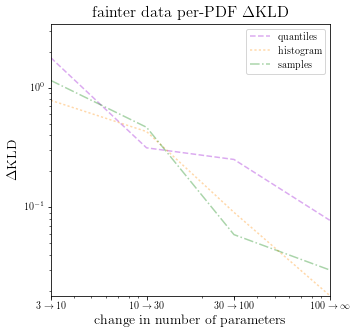

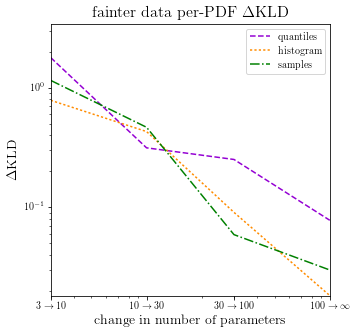

In [141]:
# comment out for NERSC
# set norm to True and run twice to match axis limits

for name in names:
    for size in sizes:
#         for stat_name in moments_to_save + metrics_to_save:
#             clear_stats(name, size, stat_name)
#         for i in instantiations:
#             top_bonusdict = {}
#             bo = '_original'+str(i)
#             plot = plot_examples(size, name, bonus=bo, norm=norm)
#             top_bonusdict[bo] = ['-', 0.25]
#             bp = '_postfit'+str(i)
#             plot = plot_examples(size, name, bonus=bp, norm=norm)
#             top_bonusdict[bp] = ['-', 0.5]
#             for n in range(len(floats)):
#                 bonusdict = top_bonusdict.copy()
#                 n_floats_use = floats[n]
#                 for f in formats:
#                     fname = str(n_floats_use)+f+str(i)
#                     plot = plot_examples(size, name, bonus=fname, norm=norm)
#                     bonusdict[fname] = [styles[f], 0.5]
#                 plot = plot_all_examples(name, size, n_floats_use, i, bonus=bonusdict)
#                 plot = plot_individual_kld(size, name, n_floats_use, i)
#                 plot = plot_estimators(size, name, n_floats_use, i)
#                 for stat_name in moments_to_save:
#                     save_moments_wrapper(name, size, n_floats_use, i, stat_name)
#                 for stat_name in metrics_to_save:
#                     save_metrics_wrapper(name, size, n_floats_use, i, stat_name)
        plot = plot_kld_stats(name, size)
#         plot = plot_pz_metrics(name, size)
#         plot = plot_pz_delta_moments(name, size)
#         plot = plot_nz_klds(name, size)
#         plot = plot_nz_moments(name, size)

In [52]:
indices = '27150  11288  54516 101230  61485  19623  50259  48744  6427  62300'
# indices = '92250   3847  83378  12742  43667  10569  31701  26828  29136  11683'
# indices += ' 43998  96531  34802  14008   5083  94955 106754  86870  23547  93601'
# indices += '  5869   5157 100074    316  96728  75727   2662  41331  41474  93074'
# indices += '   784 105537  39558 108553  46954  41754  47130  54528  34920  58321'
# indices += ' 70453 108822  98370  74756  25879  80431  61434  65169  46466   6126'
# indices += '  6466 101890 108524  96272  25660  81478  92854  24288  88348   7223'
# indices += ' 58928  49020   2141  25304  75384  34641  65491  45164  44332 107756'
# indices += ' 91896  75871  87481  24340   7056  80483  49792  20459  70865 109372'
# indices += ' 34026  53985  60089   4565  38033   5947  51576   3856  24570   3438'
# indices += ' 22431  60534  81397  16680  88137  14027  86049  21710  96081  13413'
# indices = '9604  43445  88556  50193   1408  76204 104276  48054 104136  58073'
# indices += ' 10084  32784 101990  59630  78907  27352  13652  56942  27011 101717'
# indices += ' 105840  73315  41895  21820 105664  18054  94791  29329  99846  56379'
# indices += '  13504  45749  32028  45607  56649   2589  24215   9117  97779  27706'
# indices += '  75812  14868  59759  41794  87621  99253  83269  23886  83001  67509'
# indices += '  37047  28435  72226  64501  57296  26271  13468  50067  26576   5017'
# indices += '    827  22780  65501  78088  75632  28483 108573   6032  60818  26916'
# indices += '  99955   8065  89647   4756  91047  73095  12845  10803  52331  62513'
# indices += '   6845  26550  94541   3467  37175 101384  96101 109303 110300  53161'
# indices += '  41110  31736  70330  11116  58618  52321  68545  87421  61994  48439'
# # indices = [ 14619,  66891,  67914,  20931,  97633,   7202,  46756, 109704,  93110,  59915]
# #   35851,  65657,   3292,   3838,  10862,  50447,   5316,  49503,  39363, 110951
# #   12543,  52661,  46216,  53296,  95524,  84574 ,  2607  ,56017 , 64794,   7600
# #   94746  59924  73186  21069   2579  34780   4623  93464  44621  29828
# #  111140  74609  34411  42554  32981  34904  10264   1667  42037  23986
# #   51790  98555  94971  58683  99752  87479  67286  89575  36950  84283
# #   89866  64959  53221 102714  48642  37379  95257  11874  70743  15107
# #   93651  48304  93829  64956  94703 107021  88900   7849  88808  71397
# #   26862  74765  89470   2741  56888  94275  40017  85989  94077  66553
# #   74666  90417  12553  21928  14720  53798  30290 109516  37033  95242]
# # indices = [ 59935,  44820,  26407,  84617,  98728,  35216,  73968, 105130, 844,  63892]
indices = map(int, indices.split())
all_randos = [[indices for size in sizes] for name in names]

In [ ]:
# thing = load_one_stat('ss', 100, 3, 0, 'pz_moment_deltas')
# print(np.mean(np.shape(thing['quantiles']), axis=0))

In [ ]:
# save_moments('ss', 100, 3, thing, 'pz_moment_deltas')

In [ ]:
# path = os.path.join('ss', str(100))
# loc = os.path.join(path, 'pz_moment_deltas'+str(100)+'ss')
# with open(loc+'.hkl', 'r') as pz_file:
#     pz_stats = hickle.load(pz_file)
    
# print(np.shape(pz_stats['quantiles'][0]))#N_f * n_m * n_i * n_g

In [ ]:
# modified = np.array(pz_stats['quantiles']).reshape(4, 4, 1000)*100.
# print(np.shape(modified))

In [ ]:
# print(np.shape(np.array(pz_stats[f][0]).reshape(4, 1000)))

In [ ]:
# more_modified = modified * 100.
# mean = np.mean(more_modified, axis=-1)
# print(mean)
# std = np.std(more_modified, axis=-1)
# print(std)

In [ ]:
# # print(np.shape(modified))
# # plt.hist(modified[0][3])
# weird_x = np.log(np.array(floats))

# moment_num = 3
# for s in range(3):
#     f = formats[s]
#     const = 0.1
#     f_factor = const * (s - 1)
#     new_data = np.array(pz_stats[f][moment_num]).reshape(4, 1000)*100.
#     plt.plot(np.exp(weird_x+f_factor), np.median(new_data, axis=-1), linestyle=styles[f], marker=moment_shapes[moment_num], mfc='none', markersize=5, alpha=0.5, color=colors[f])
#     violin = plt.violinplot(list(new_data), np.exp(weird_x+f_factor), showextrema=False, showmeans=False, showmedians=False, widths=np.exp(weird_x+const/2.)-np.exp(weird_x))
# #     for partname in ['cmedians']:
# #         vp = violin[partname]
# #         vp.set_edgecolor(colors[f])
# #         vp.set_linewidth(3)
# # Make the violin body blue with a red border:
#     for vp in violin['bodies']:
#         vp.set_facecolor(colors[f])
# #         vp.set_edgecolor('k')
# #         vp.set_linewidth(0)
#         vp.set_alpha(0.5)
# plt.semilogx()
# plt.ylim(-50., 50.)

In [ ]:
# print(np.shape(new_data))

In [ ]:
# plt.boxplot(list(new_data), floats, '')

In [ ]:
# print(np.shape(pz_stats['quantiles'][0][0]))

In [ ]:
# print(violin.keys())

In [ ]:
# help(plt.boxplot)